In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# True kernal
def lennard_jones(r, epsilon=1.0, sigma=1.0):
    r = np.maximum(r, 1e-10)
    # I want to see the repulsive force more clearly
    return 4 * epsilon * ((sigma/r)**12 - (sigma/r)**6)

In [53]:
def simulate_particle_system(N=20, T=5, dt=0.01, d=1, epsilon=1.0, sigma=1.0, noise_level=0.1):
    """
    Simulate a particle system with Lennard-Jones interaction kernel.

    Parameters:
    -----------
    N : int
        Number of particles
    T : float
        Total simulation time
    dt : float
        Time step
    d : int
        Dimension of the space
    epsilon, sigma : float
        Parameters of the Lennard-Jones potential
    noise_level : σ in the SDE

    Returns:
    --------
    dict
        Dictionary containing trajectories, velocities, and other data
    """
    n_steps = int(T/dt)

    # Leave some space between particles, prob need to change the spacing
    if d == 1:
        X = np.linspace(0, 2*sigma*N, N).reshape(N, d) + 0.1*np.random.randn(N, d)
    else:
        X = np.random.uniform(0, 5*sigma, (N, d))

    trajectories = np.zeros((n_steps, N, d))
    velocities = np.zeros((n_steps, N, d))
    pairwise_distances = np.zeros((n_steps, N, N))

    for t in range(n_steps):
        trajectories[t] = X

        # Calculate pairwise distances
        for i in range(N):
            for j in range(N):
                if i != j:
                    pairwise_distances[t, i, j] = np.linalg.norm(X[i] - X[j])

        # Calculate R_φ[X(t)]
        R_phi = np.zeros_like(X)

        for i in range(N):
            for j in range(N):
                if i != j:
                    r_ij = pairwise_distances[t, i, j]
                    direction = (X[i] - X[j]) / r_ij
                    R_phi[i] += (1/N) * lennard_jones(r_ij, epsilon, sigma) * direction

        velocities[t] = R_phi
        X = X + R_phi * dt + noise_level * np.sqrt(dt) * np.random.randn(N, d)

    return {
        'trajectories': trajectories,
        'velocities': velocities,
        'pairwise_distances': pairwise_distances,
        'time': np.arange(0, T, dt)
    }

In [48]:
def heat_kernel_basis(r, centers, scales):
    r = r.reshape(-1, 1)
    centers = centers.reshape(1, -1)
    scales = scales.reshape(1, -1)

    # Compute heat kernel basis values
    basis_values = np.exp(-((r - centers) / scales) ** 2)

    return basis_values

In [49]:
# tLSE
def compute_A_b(trajectories, velocities, pairwise_distances, centers, scales):
    n_steps, N, d = trajectories.shape
    n_basis = len(centers)
    A = np.zeros((n_basis, n_basis))
    b = np.zeros(n_basis)

    subset_indices = np.linspace(0, n_steps-1, min(100, n_steps), dtype=int)

    for t in subset_indices:
        # For each particle
        for i in range(N):
            #R_ψ_k[X^t]_i for all basis functions k
            R_basis = np.zeros((n_basis, d))
            for j in range(N):
                if i != j:
                    r_ij = pairwise_distances[t, i, j]
                    direction = (trajectories[t, i] - trajectories[t, j]) / r_ij
                    basis_vals = heat_kernel_basis(np.array([r_ij]), centers, scales)[0]

                    for k in range(n_basis):
                        R_basis[k] += (1/N) * basis_vals[k] * direction

            # Update normal matrix
            for k in range(n_basis):
                for l in range(n_basis):
                    A[k, l] += np.dot(R_basis[k], R_basis[l]) / (len(subset_indices) * N)

            # Update normal vector
            for k in range(n_basis):
                b[k] += np.dot(R_basis[k], velocities[t, i]) / (len(subset_indices) * N)
    return A, b

def tamed_least_squares(A, b, c_L=0.1, plot_eigenvalues=True):
    """
    Parameters:
    -----------
    A : ndarray
        Normal matrix
    b : ndarray
        Normal vector
    c_L : float
        Coercivity constant

    Returns:
    --------
    theta : ndarray
        Estimated coefficients
    lambda_min : float
        Smallest eigenvalue of A
    """
    eigvals = linalg.eigvalsh(A)
    lambda_min = np.min(eigvals)

    if plot_eigenvalues:
        plt.figure(figsize=(10, 6))

        # Plot eigenvalues
        plt.semilogy(np.arange(len(eigvals)), np.sort(eigvals), 'o-', label='Eigenvalues')

        # Plot threshold
        threshold = 0.25 * c_L
        plt.axhline(threshold, color='r', linestyle='--',
                   label=f'Threshold (0.25*c_L = {threshold:.6f})')

        # Highlight eigenvalues below threshold
        below_threshold = np.sort(eigvals) < threshold
        if np.any(below_threshold):
            plt.semilogy(np.arange(len(eigvals))[below_threshold],
                       np.sort(eigvals)[below_threshold], 'rx', markersize=10,
                       label='Eigenvalues below threshold')

        plt.title('Eigenvalue Spectrum of Normal Matrix')
        plt.xlabel('Index')
        plt.ylabel('Eigenvalue (log scale)')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Taming
    if lambda_min > 0.25 * c_L:
        theta = linalg.solve(A, b)
    else:
        print(f"Warning: Matrix is ill-conditioned (λ_min = {lambda_min:.6f}). Using tamed estimator (zero).")
        theta = np.zeros_like(b)

    return theta, lambda_min

# 6. Main function to estimate the interaction kernel
def estimate_interaction_kernel(sim_data, n_basis=20, c_L=0.1):
    """
    Estimate the interaction kernel using tLSE with heat kernel basis.

    Parameters:
    -----------
    sim_data : dict
        Simulation data
    n_basis : int
        Number of basis functions
    c_L : float
        Coercivity constant

    Returns:
    --------
    dict
        Estimation results
    """
    # Extract data
    trajectories = sim_data['trajectories']
    velocities = sim_data['velocities']
    pairwise_distances = sim_data['pairwise_distances']

    # Get range of pairwise distances
    all_distances = pairwise_distances.flatten()
    all_distances = all_distances[all_distances > 0]
    r_min, r_max = np.min(all_distances), np.max(all_distances)

    # Create basis centers and scales
    centers = np.linspace(r_min, r_max, n_basis)
    scales = np.ones(n_basis) * (r_max - r_min) / (2 * n_basis)

    A, b = compute_A_b(trajectories, velocities, pairwise_distances, centers, scales)
    theta, lambda_min = tamed_least_squares(A, b, c_L, plot_eigenvalues=True)

    # Define the estimated kernel function
    def estimated_kernel(r):
        basis_vals = heat_kernel_basis(np.array([r]), centers, scales)[0]
        return np.sum(theta * basis_vals)

    r_grid = np.linspace(r_min, r_max, 10)
    kernel_values = np.array([estimated_kernel(r) for r in r_grid])

    return {
        'coef': theta,
        'centers': centers,
        'scales': scales,
        'estimated_kernel': estimated_kernel,
        'r_grid': r_grid,
        'kernel_values': kernel_values,
        'lambda_min': lambda_min
    }


In [50]:
def plot_eigenvalues(eigvals, c_L):
        plt.figure(figsize=(10, 6))
        plt.semilogy(np.arange(len(eigvals)), np.sort(eigvals), 'o-', label='Eigenvalues')

        # Plot threshold
        threshold = 0.25 * c_L
        plt.axhline(threshold, color='r', linestyle='--',
                   label=f'Threshold (0.25*c_L = {threshold:.6f})')

        # Highlight eigenvalues below threshold
        below_threshold = np.sort(eigvals) < threshold
        if np.any(below_threshold):
            plt.semilogy(np.arange(len(eigvals))[below_threshold],
                       np.sort(eigvals)[below_threshold], 'rx', markersize=10,
                       label='Eigenvalues below threshold')

        plt.title('Eigenvalue Spectrum of Normal Matrix')
        plt.xlabel('Index')
        plt.ylabel('Eigenvalue (log scale)')
        plt.legend()
        plt.grid(True)
        plt.show()

In [60]:
def run_kernel_estimation_example():
    # Parameters
    N = 30      # Number of particles
    T = 5      # Simulation time
    dt = 0.01   # Time step
    d = 1       # Dimension (1D for simplicity)
    epsilon = 1.0
    sigma = 1.0
    noise_level = 0.5

    # eq 2.6, scale by 10?
    c_L = 1*(N-1)/(N**2)

    print(f"Simulating particle system with Lennard-Jones potential...")
    sim_data = simulate_particle_system(N, T, dt, d, epsilon, sigma, noise_level)

    print(f"Estimating interaction kernel...")
    # This one is suggested by claude, I really dont know how many n_basis I should use?
    n_basis = int(np.ceil(np.sqrt(T/dt)/5))
    est_result = estimate_interaction_kernel(sim_data, n_basis, c_L)

    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    for i in range(min(10, N)):  # Show first ? particles
        plt.plot(sim_data['time'], sim_data['trajectories'][:, i, 0])
    plt.title('Particle Trajectories')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    r_grid = est_result['r_grid']
    true_values = lennard_jones(r_grid, epsilon, sigma)
    plt.plot(r_grid, true_values, 'b-', label='True Kernel (Lennard-Jones)')
    plt.plot(r_grid, est_result['kernel_values'], 'r--', label='Estimated Kernel')
    plt.scatter(est_result['centers'], est_result['coef'], c='g', marker='o',
                alpha=0.5, label='Basis Coefficients')
    plt.title('Interaction Kernel Estimation')
    plt.xlabel('Distance (r)')
    plt.ylabel('Interaction Strength')
    plt.legend()
    plt.grid(True)

    # Plot distribution of pairwise distances
    plt.subplot(2, 2, 3)
    all_distances = sim_data['pairwise_distances'].flatten()
    all_distances = all_distances[all_distances > 0]
    plt.hist(all_distances, bins=30, alpha=0.7)
    plt.title('Distribution of Pairwise Distances')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Plot basis functions
    plt.subplot(2, 2, 4)
    r = np.linspace(r_grid[0], r_grid[-1], 500)
    basis = heat_kernel_basis(r, est_result['centers'], est_result['scales'])
    for i in range(min(10, len(est_result['centers']))):
        plt.plot(r, basis[:, i], alpha=0.5)
    plt.title('Heat Kernel Basis Functions')
    plt.xlabel('Distance (r)')
    plt.ylabel('Basis Value')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Smallest eigenvalue: {est_result['lambda_min']:.6f}")
    print(f"Used {n_basis} basis functions")

    return sim_data, est_result

Simulating particle system with Lennard-Jones potential...
Estimating interaction kernel...


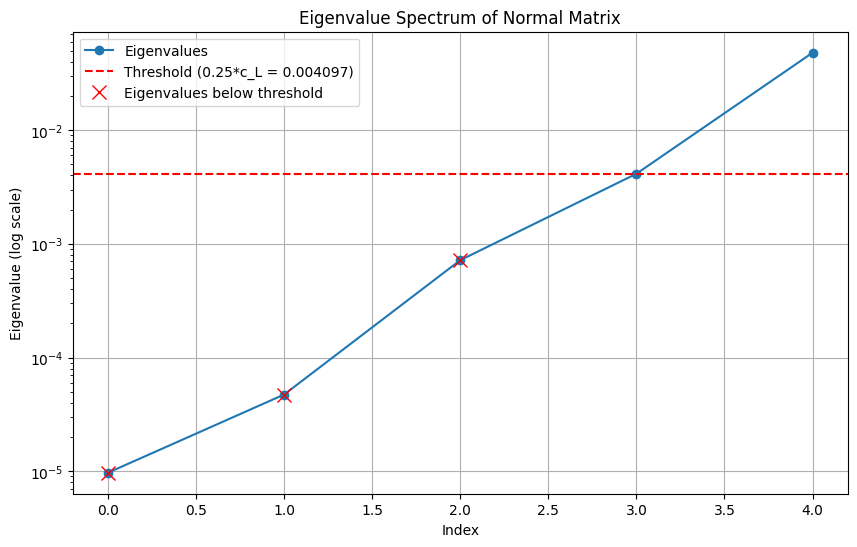

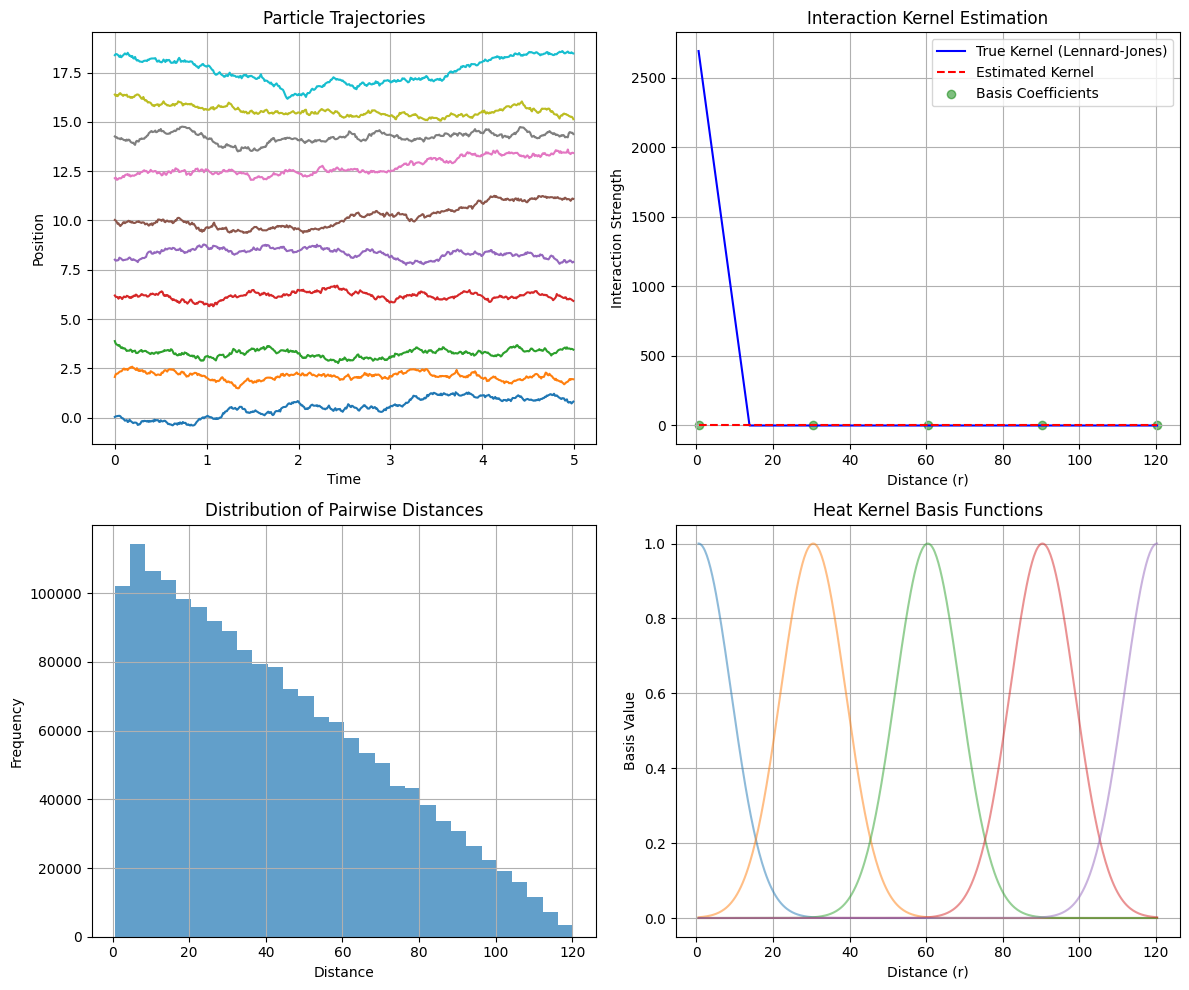

Smallest eigenvalue: 0.000010
Used 5 basis functions


In [61]:
if __name__ == "__main__":
    sim_data, est_result = run_kernel_estimation_example()